### SI 650 Homework 4

#### Import library

In [4]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

# your modules are imported here
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter, read_dataset
from ranker import Ranker, BM25, CrossEncoderScorer, PersonalizedBM25
from vector_ranker import VectorRanker
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker

from sentence_transformers import SentenceTransformer
from relevance import map_score, ndcg_score, run_relevance_tests
import torch

import matplotlib.pyplot as plt
import seaborn as sns

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Basic data setup**

In [3]:
# change these to point to actual file paths
STOPWORD_PATH = 'stopwords.txt'
DATASET_PATH = 'wikipedia_200k_dataset.jsonl.gz'
EDGELIST_PATH = 'edgelist.csv.gz'
NETWORK_STATS_PATH = 'network_stats.csv'
DOC_CATEGORY_INFO_PATH = 'doc_category_info.json'
RECOGNIZED_CATEGORY_PATH = 'recognized_categories.txt'
DOC2QUERY_PATH = 'doc2query.csv'
MAIN_INDEX = 'main_index_augmented'
TITLE_INDEX = 'title_index'
RELEVANCE_TRAIN_DATA = 'hw4_relevance.train.csv'
RELEVANCE_DEV_DATA = 'hw4_relevance.dev.csv'
RELEVANCE_TEST_DATA = 'hw4_relevance.test.csv'
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = 'wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
DOCUMENT_ID_TEXT = 'document-ids.txt'
PERSON_ATTRIBUTES = 'person-attributes.csv'

**Load Basic Statistics**

In [3]:
# Load in the stopwords
stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
print(f'Stopwords collected {len(stopwords)}')

# Load the document category info
doc_category_info = {}
with open(DOC_CATEGORY_INFO_PATH, 'r') as f:
    doc_category_info = json.load(f)
    doc_category_info = {int(k): v for k, v in doc_category_info.items()}

# Load the recognized categories
recognized_categories = set()
with open(RECOGNIZED_CATEGORY_PATH, 'r') as f:
    recognized_categories = set(map(lambda x: x.strip(), f.readlines()))
print(f'Recognized categories {len(recognized_categories)}')

# Load the network stats
network_feats = {}
networks_stats = pd.read_csv(NETWORK_STATS_PATH)
for row in tqdm(networks_stats.iterrows()):
    network_feats[row[1]['docid']] = row[1][1:].to_dict()
print(f'Network stats collection {len(network_feats)}')

Stopwords collected 543
Recognized categories 118


999841it [00:21, 46143.29it/s]

Network stats collection 999841


#### Problem 1

TOP 10 common labels for each person attribute

In [5]:
top_10_attributes = {}
person_attr_df = pd.read_csv(PERSON_ATTRIBUTES)
for attr in person_attr_df.columns[1:-1]:
    top_10_attributes[attr] = person_attr_df[attr].value_counts()[:10].to_dict()

top_10_attributes_df = pd.DataFrame(
    {
        k: list(v.keys()) + [''] * (10 - len(v.keys()))
        for k, v in top_10_attributes.items()
    }
)
top_10_attributes_df

,Ethnicity,Gender,Religious_Affiliation,Political_Party
0,African Americans,male,Catholic Church,Democratic Party
1,Jewish people,female,Islam,Republican Party
2,Germans,trans woman,atheism,Conservative Party
3,English people,non-binary,Catholicism,Labour Party
4,French,genderfluid,Hinduism,Indian National Congress
5,American Jews,cisgender man,Judaism,Bharatiya Janata Party
6,Italians,male organism,Christianity,Communist Party of the Soviet Union
7,Greeks,,Lutheranism,Nazi Party
8,Serbs,,Anglicanism,Chinese Communist Party
9,Arabs,,Sunni Islam,Liberal Party


Preparation for the pipeline

In [5]:
# Doc2Query: augment the document with the query
doc_augment_dict = defaultdict(lambda: [])
doc2query_df = pd.read_csv(DOC2QUERY_PATH).dropna()
for row in tqdm(doc2query_df.iterrows(), total=len(doc2query_df)):
    doc_id = int(row[1]['doc'])
    doc_query = row[1]['query']
    doc_augment_dict[doc_id].append(doc_query)
print(f'Doc2Query augments {len(doc_augment_dict)} documents')

# tokenizer: regex tokenizer
preprocessor = RegexTokenizer('\w+')

# Reload the computed index
main_index = Indexer.load_index(MAIN_INDEX)
title_index = Indexer.load_index(TITLE_INDEX)

# create the raw text dictionary by going through the wiki dataset
# this dictionary should store only the first 500 words of the raw documents text
raw_text_dict = {}
for doc in tqdm(read_dataset(DATASET_PATH, 200_000, 1), total=200_000):
    doc_id = int(doc['docid'])
    raw_text_dict[doc_id] = " ".join(preprocessor.tokenize(doc['text'])[:500])

# load the precomputed vector embeddings
encoded_docs = None
with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)

# load the document ids
with open(DOCUMENT_ID_TEXT, 'r') as f:
    document_ids = f.read().splitlines()
document_ids = [int(x) for x in document_ids]

100%|██████████| 599565/599565 [00:07<00:00, 82609.66it/s]


Doc2Query augments 200000 documents


100%|██████████| 200000/200000 [01:15<00:00, 2639.66it/s] 


Build up the four pipelines

In [6]:
# feature extractor
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                         preprocessor, stopwords, recognized_categories,
                         network_feats, None)

# BM25 ranker
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25, raw_text_dict=raw_text_dict)

# BM25 + L2R pipeline
pipeline_1 = L2RRanker(main_index, title_index, preprocessor,
                       stopwords, ranker, fe)

# VectorRanker
bi_encoder_name = 'sentence-transformers/msmarco-MiniLM-L12-cos-v5'
vec_ranker = VectorRanker(bi_encoder_name, encoded_docs, document_ids)

# VectorRanker + L2R pipeline
pipeline_2 = L2RRanker(main_index, title_index, preprocessor, stopwords,
                       vec_ranker, fe)

# Train the pipeline
pipeline_1.train(RELEVANCE_TRAIN_DATA, RELEVANCE_DEV_DATA)
pipeline_2.train(RELEVANCE_TRAIN_DATA, RELEVANCE_DEV_DATA)

Preparing: 100%|██████████| 19/19 [00:01<00:00, 16.26it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


Preparing: 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


Compute the rank

In [7]:
# import l2r
# from importlib import reload
# reload(l2r)

In [8]:
# queries = ["person", "woman", "teacher", "role model", "professional"]
# pseudo_args = {"pseudofeedback_num_docs" : 10}
# pipe_name = ["BM25_L2R", "BM25_L2R_Feedback", "VectorRanker_L2R", "VectorRanker_L2R_Feedback"]

# for query in tqdm(queries):
#     bm25_l2r_results = pipeline_1.query(query)
#     bm25_l2r_feedback_results = pipeline_1.query(query, **pseudo_args)
#     vec_l2r_results = pipeline_2.query(query)
#     vec_l2r_feedback_results = pipeline_2.query(query, **pseudo_args)
#     results = [bm25_l2r_results, bm25_l2r_feedback_results, vec_l2r_results, vec_l2r_feedback_results]
#     for name, result in zip(pipe_name, results):
#         doc_rank = {doc_score[0]: rank + 1 for rank, doc_score in enumerate(result)}
#         person_attr_df[name + "_" + query] = person_attr_df['docid'].map(doc_rank)
#         large_rank = len(doc_rank)
#         person_attr_df[name + "_" + query] = person_attr_df[name + "_" + query].fillna(large_rank)

# person_attr_df.to_csv("person-attributes-ranked.csv", index=False)

In [8]:
person_attr_df_rank.head()

,title,Ethnicity,Gender,Religious_Affiliation,Political_Party,docid,BM25_L2R_person,BM25_L2R_Feedback_person,VectorRanker_L2R_person,VectorRanker_L2R_Feedback_person,...,VectorRanker_L2R_teacher,VectorRanker_L2R_Feedback_teacher,BM25_L2R_role model,BM25_L2R_Feedback_role model,VectorRanker_L2R_role model,VectorRanker_L2R_Feedback_role model,BM25_L2R_professional,BM25_L2R_Feedback_professional,VectorRanker_L2R_professional,VectorRanker_L2R_Feedback_professional
0,George Washington,NaN,male,Episcopal Church,independent politician,11968,33783,9300,16949,17145,...,9856,9874,68511,18593,36483,36368,28895,9190,20885,19614
1,Douglas Adams,White British,male,NaN,NaN,8091,12407,12046,7706,8819,...,9856,9874,71531,71533,71427,71374,24887,24169,12652,14222
2,George W. Bush,NaN,male,United Methodist Church,Republican Party,3414021,27661,3745,13447,15065,...,9856,9874,70116,4364,31319,31424,28973,28958,28905,28878
3,Diego Velázquez,Spaniards,male,NaN,NaN,77423,33850,33859,33465,33413,...,8472,8694,18185,20143,36654,33052,28973,28958,28905,28878
4,Augusto Pinochet,NaN,male,Catholicism,independent politician,18933396,32900,6941,5647,6653,...,9856,9874,7714,3810,24027,26033,28973,28958,28905,28878


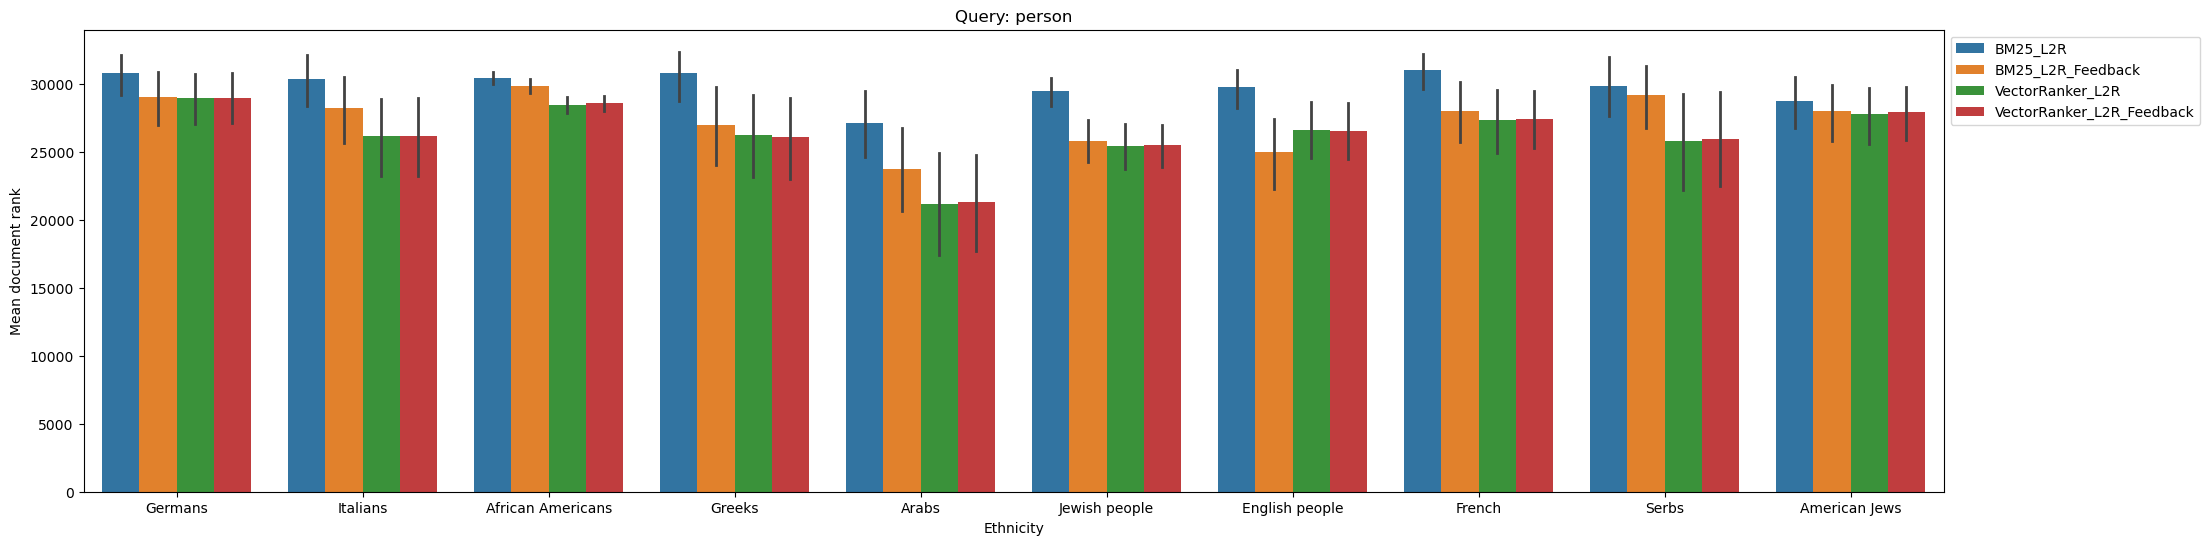

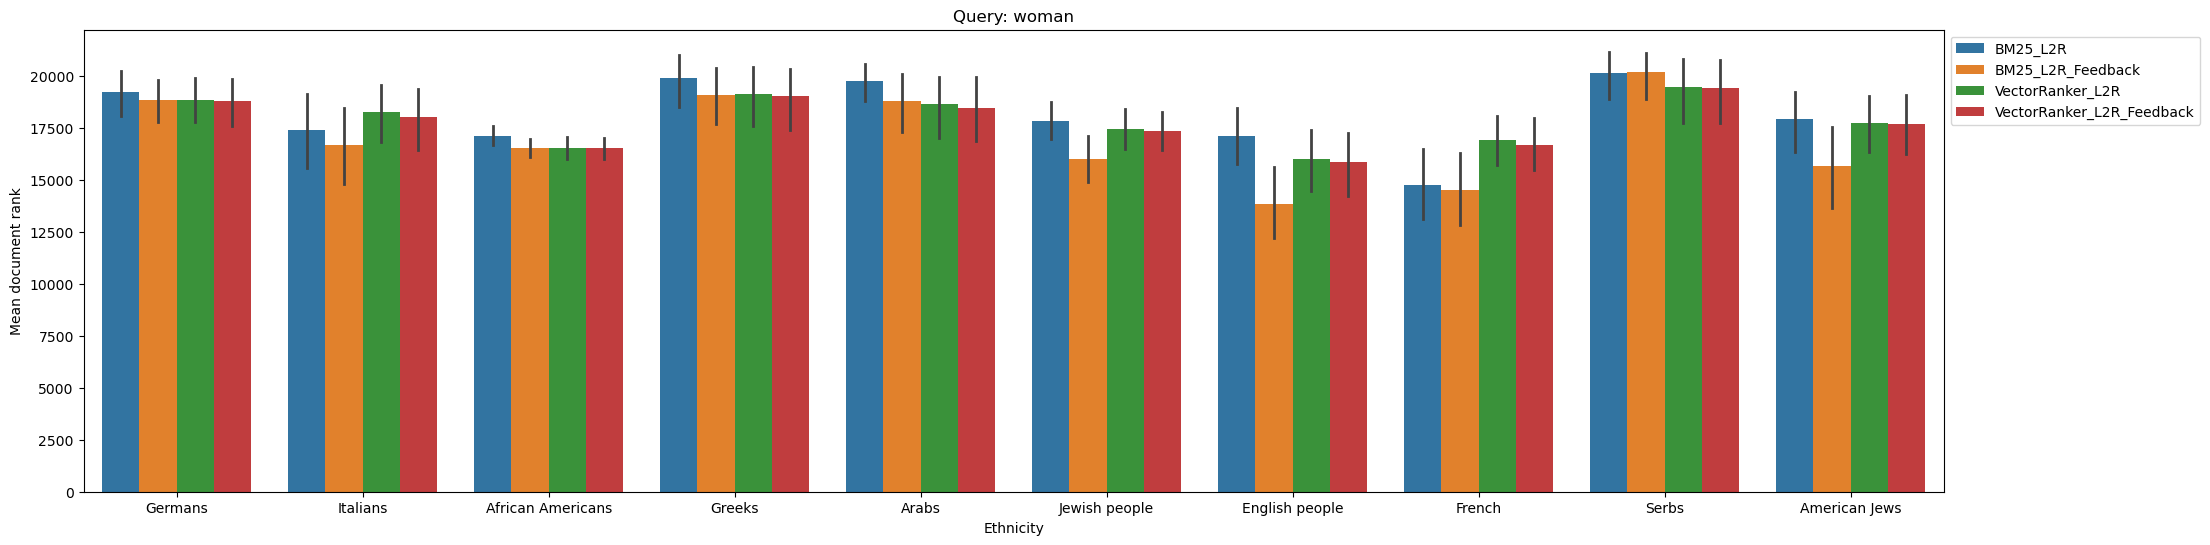

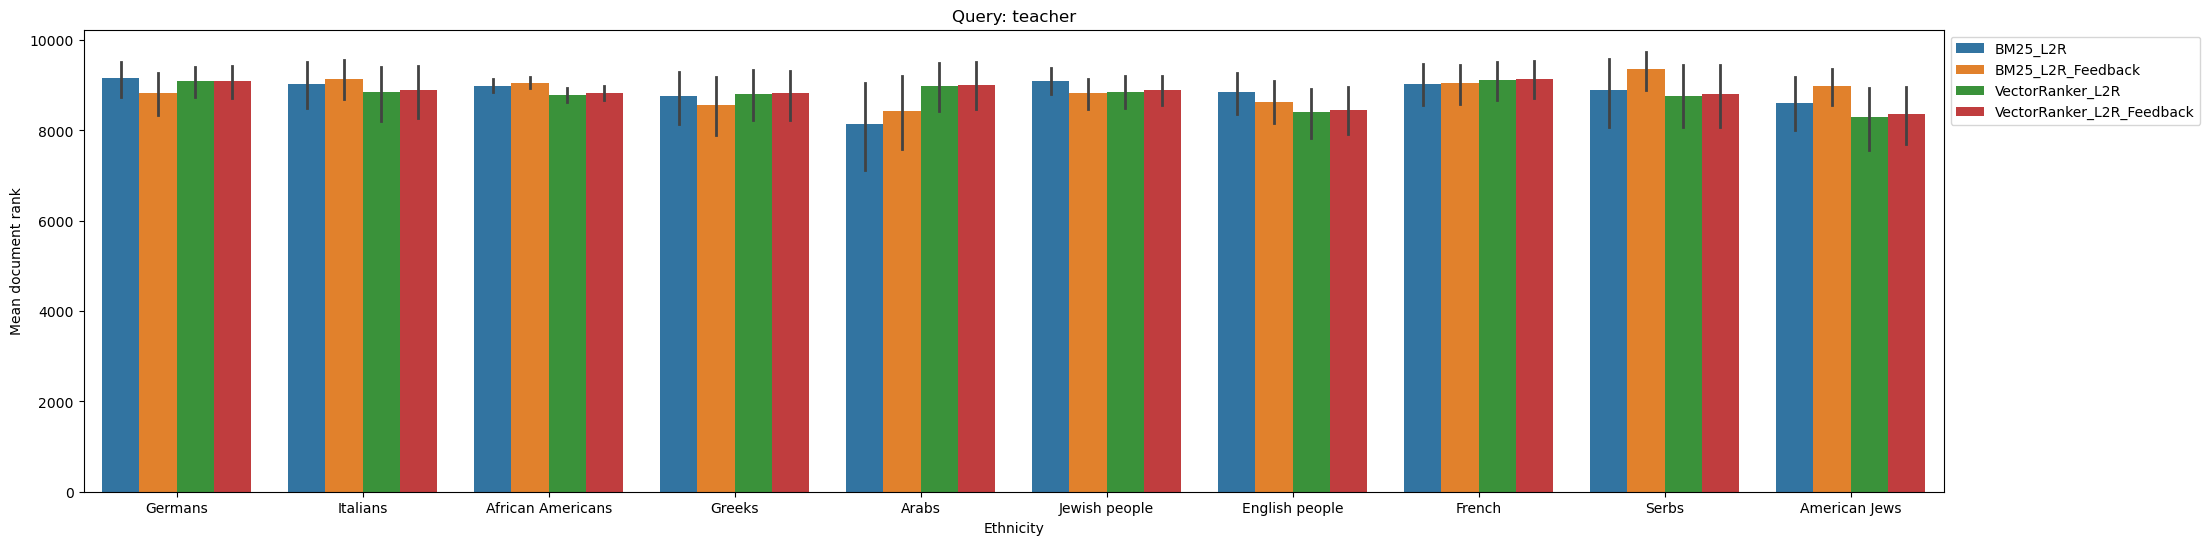

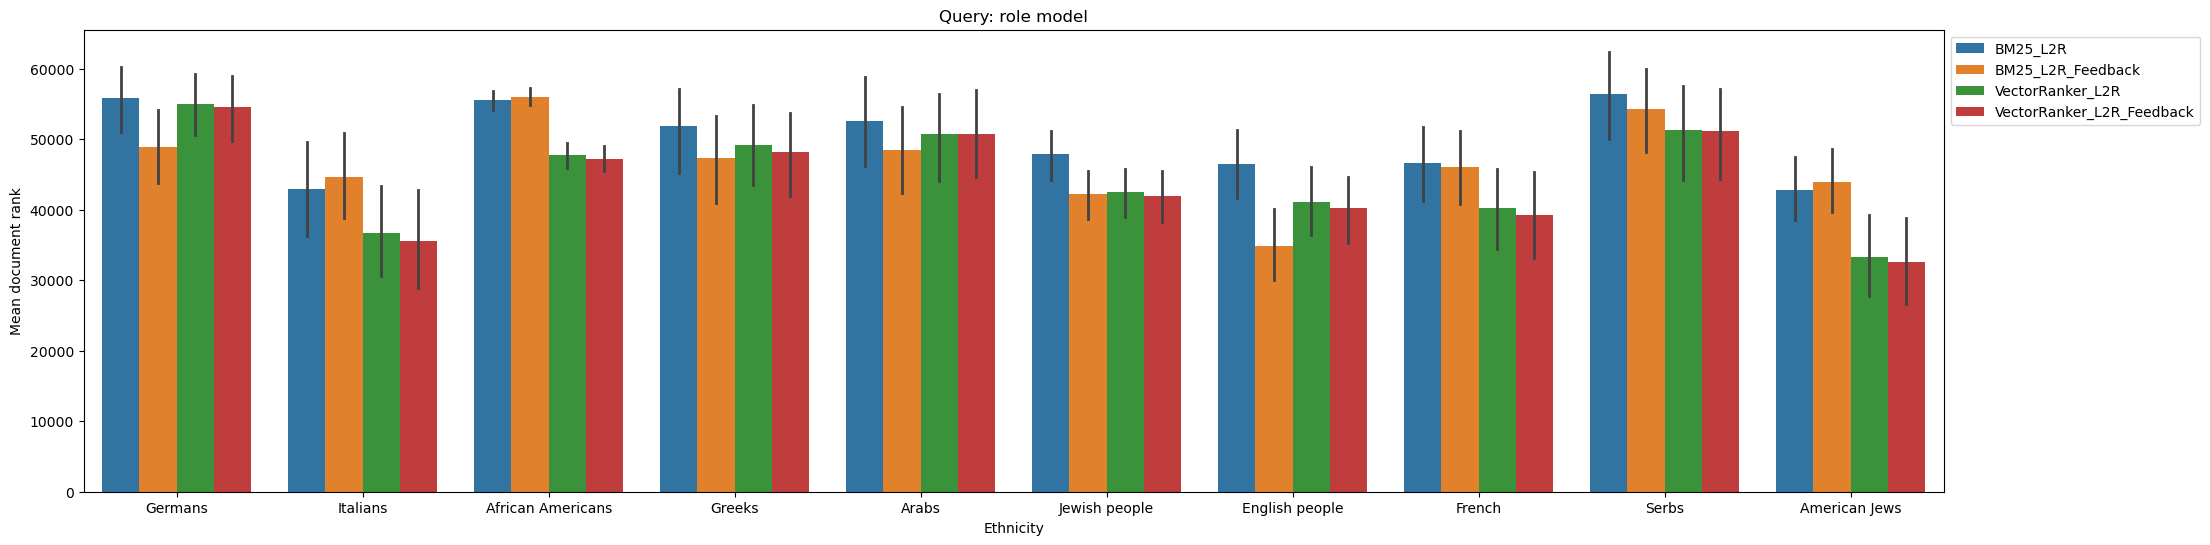

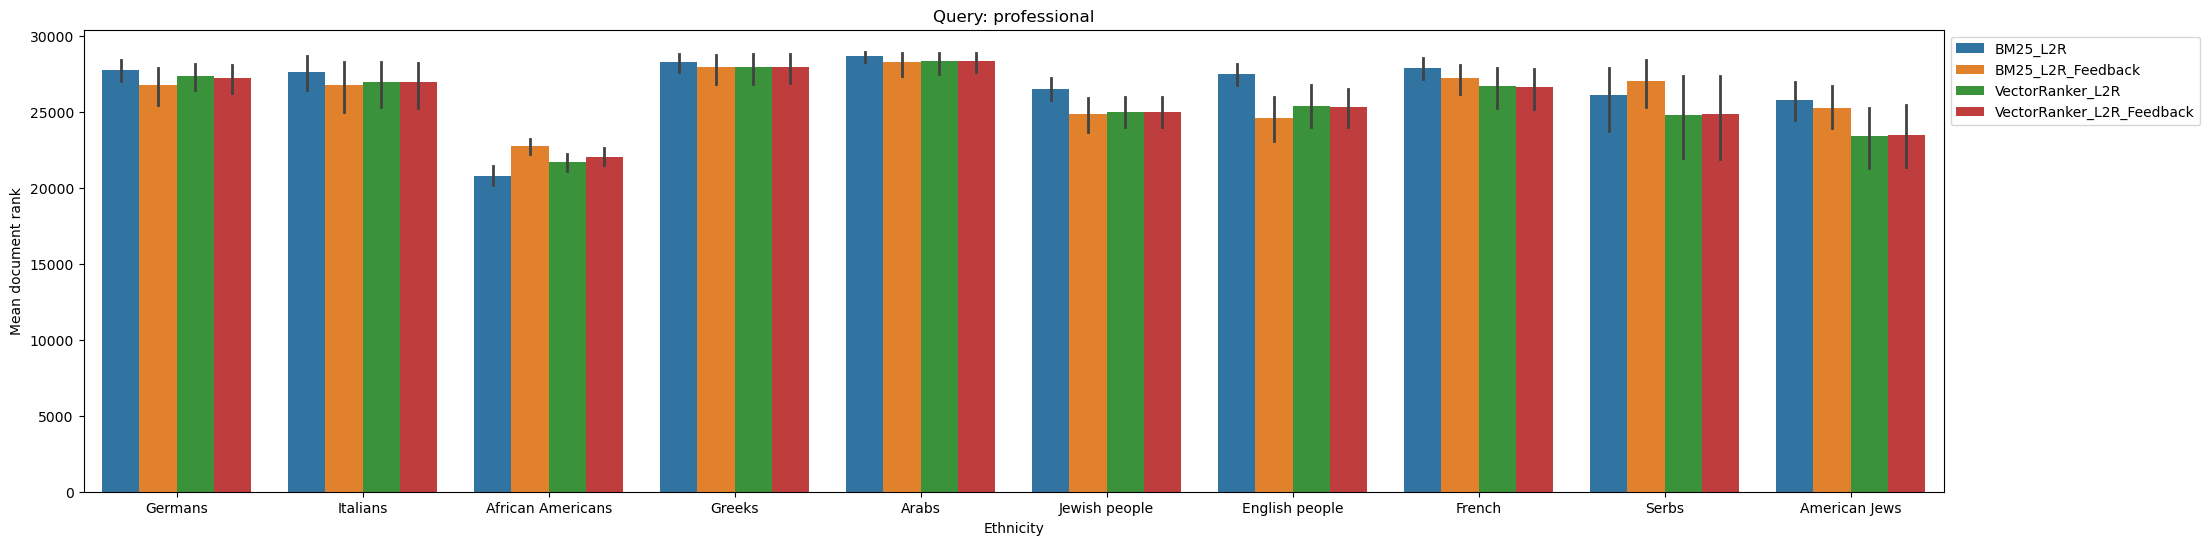

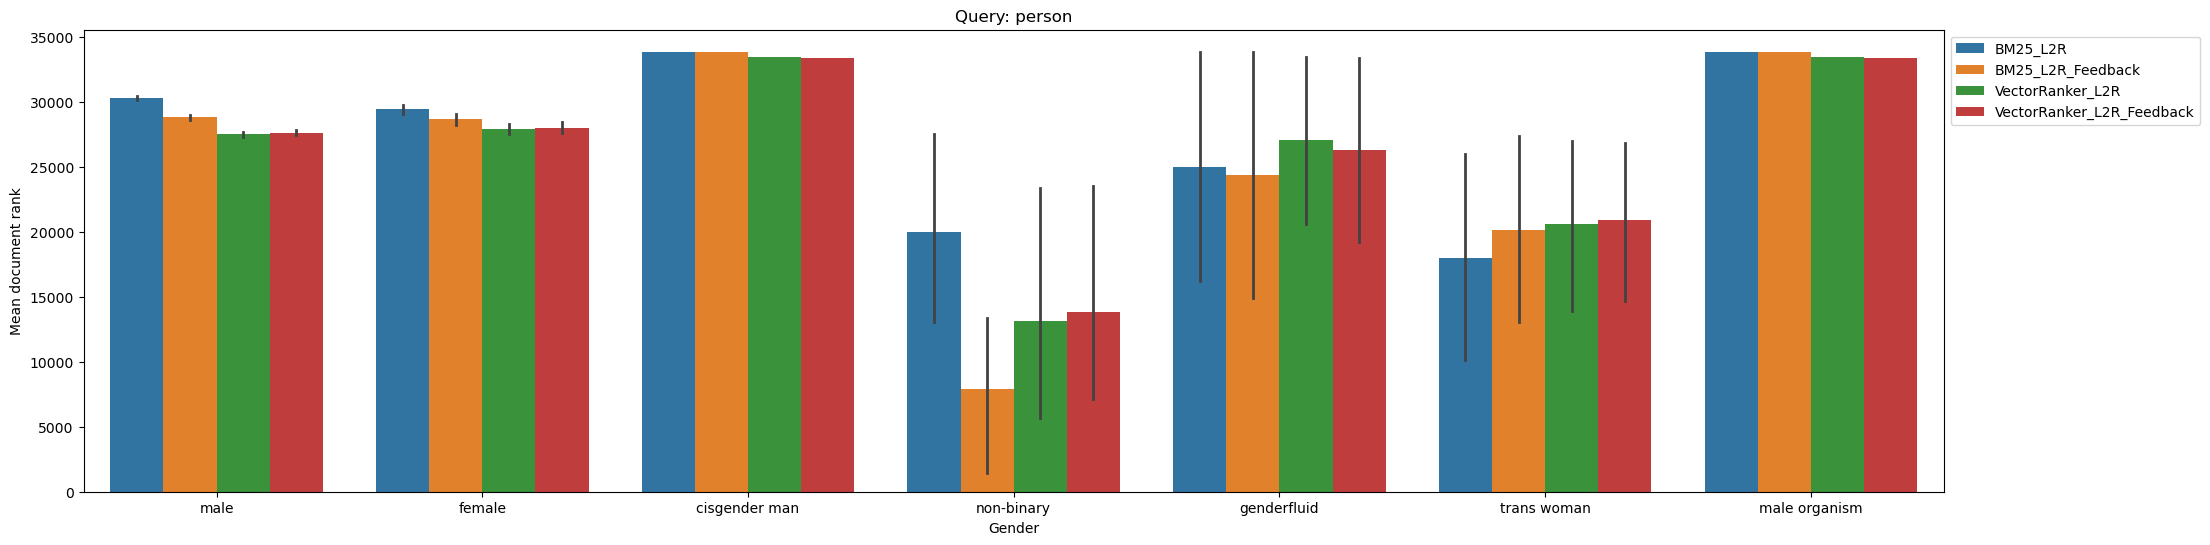

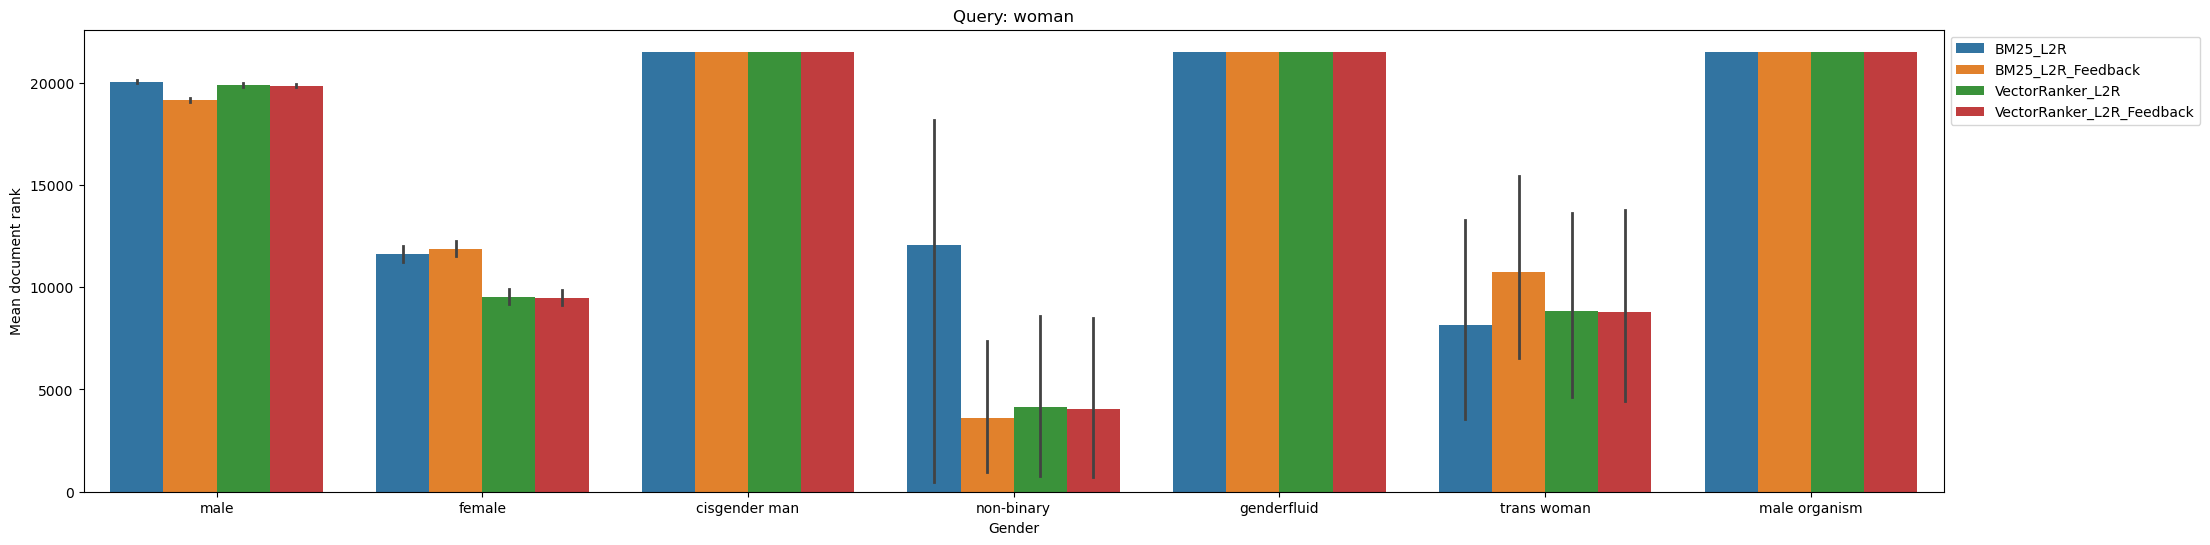

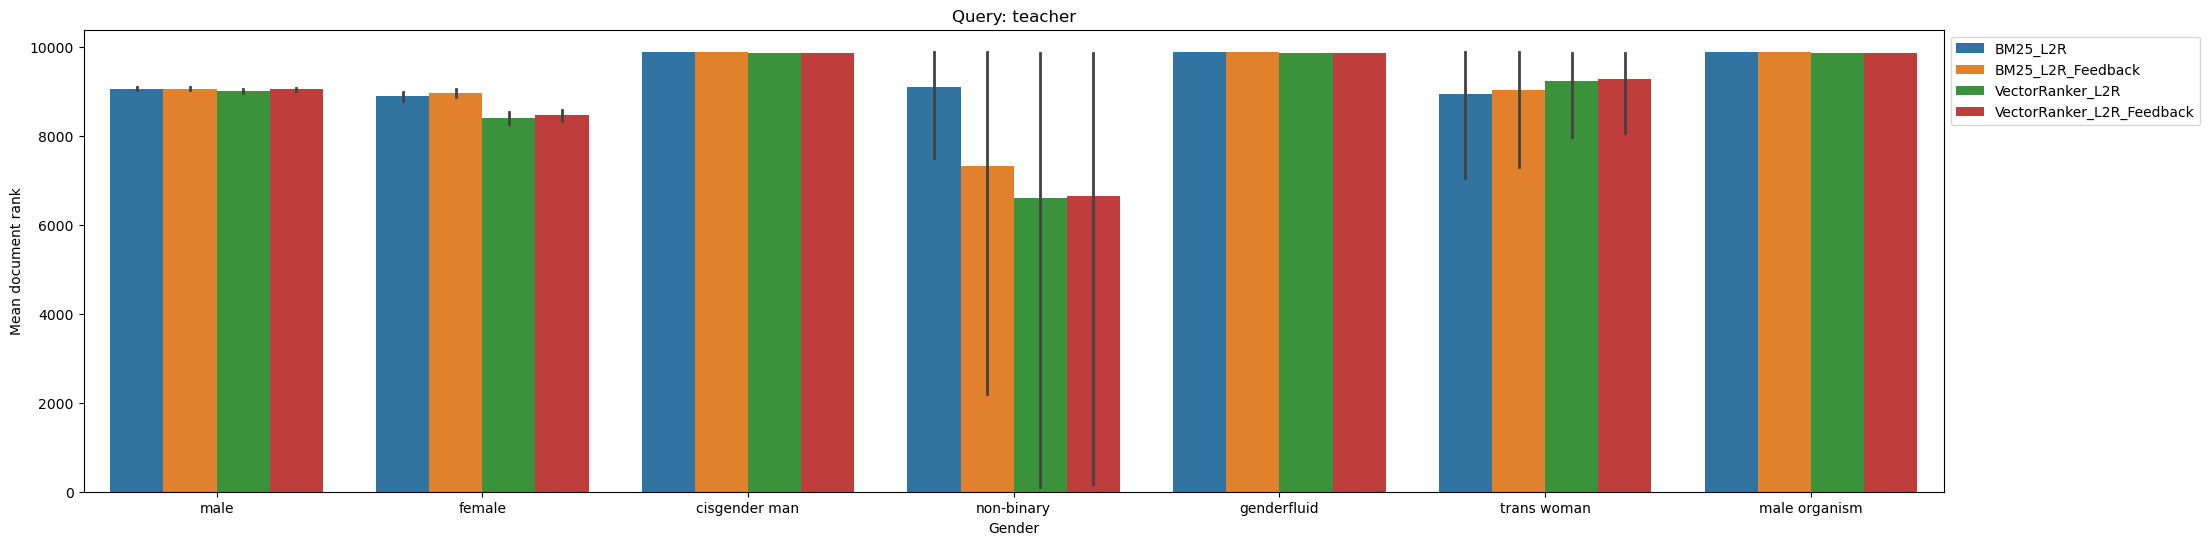

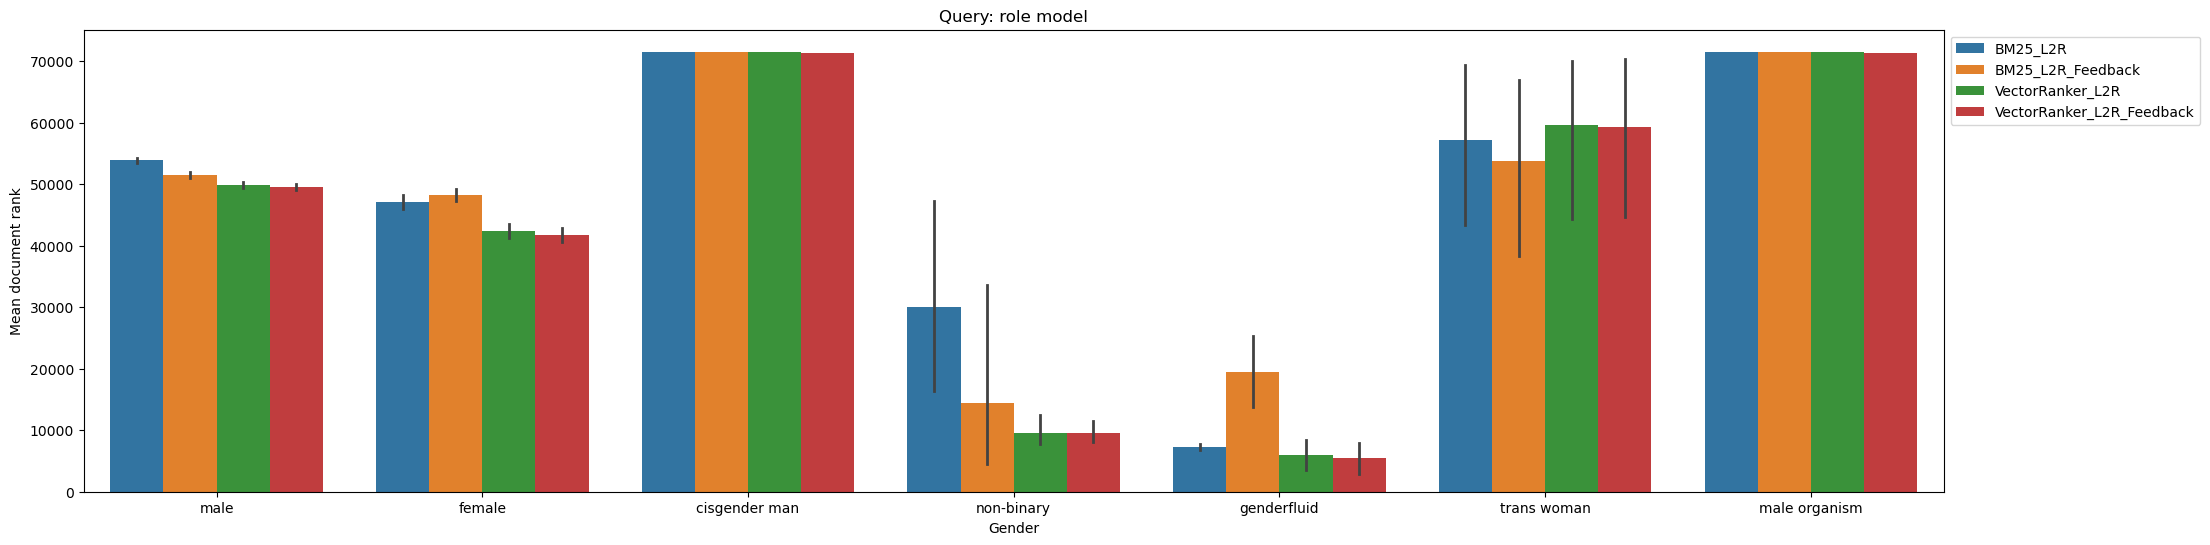

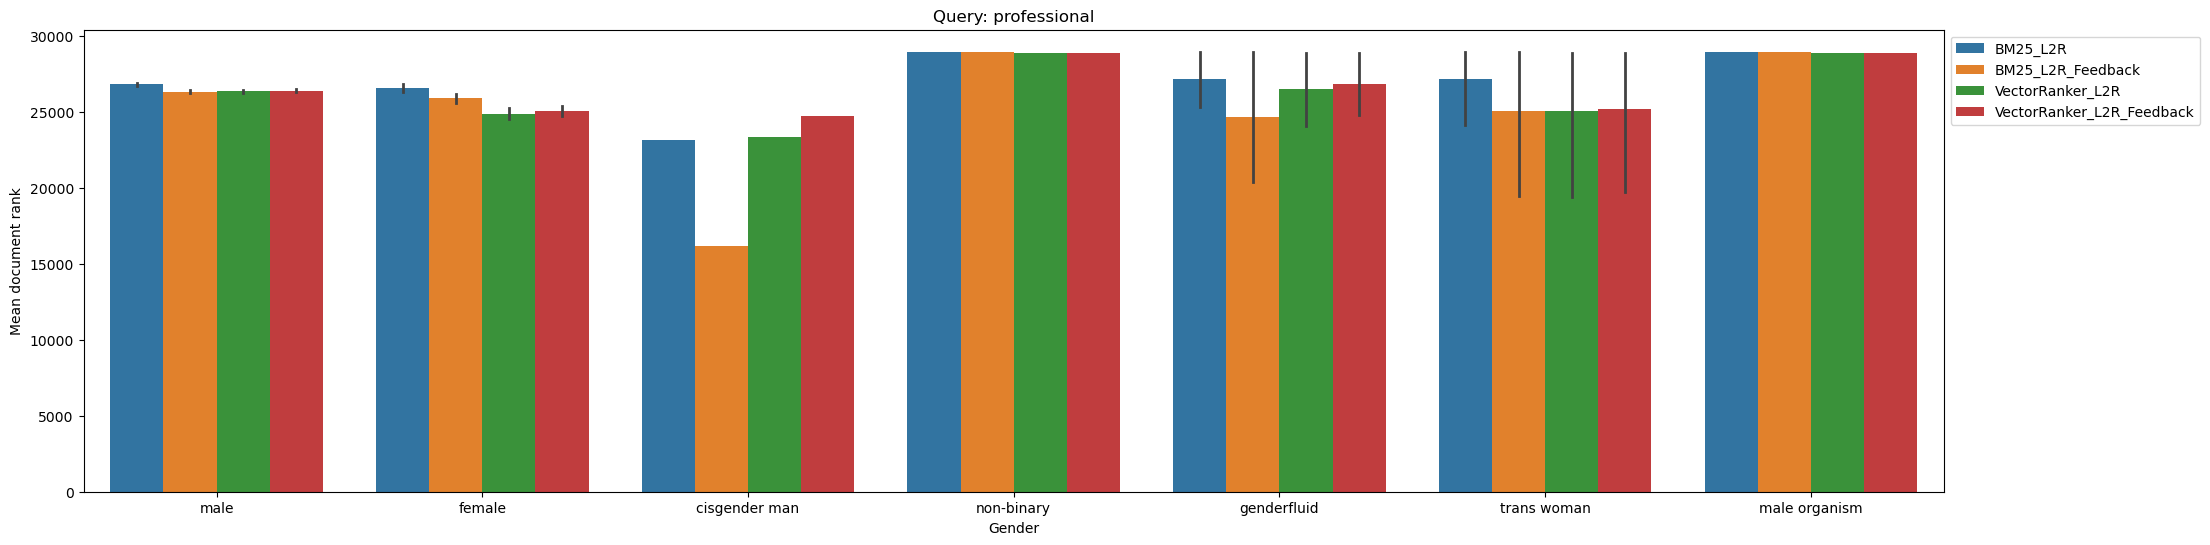

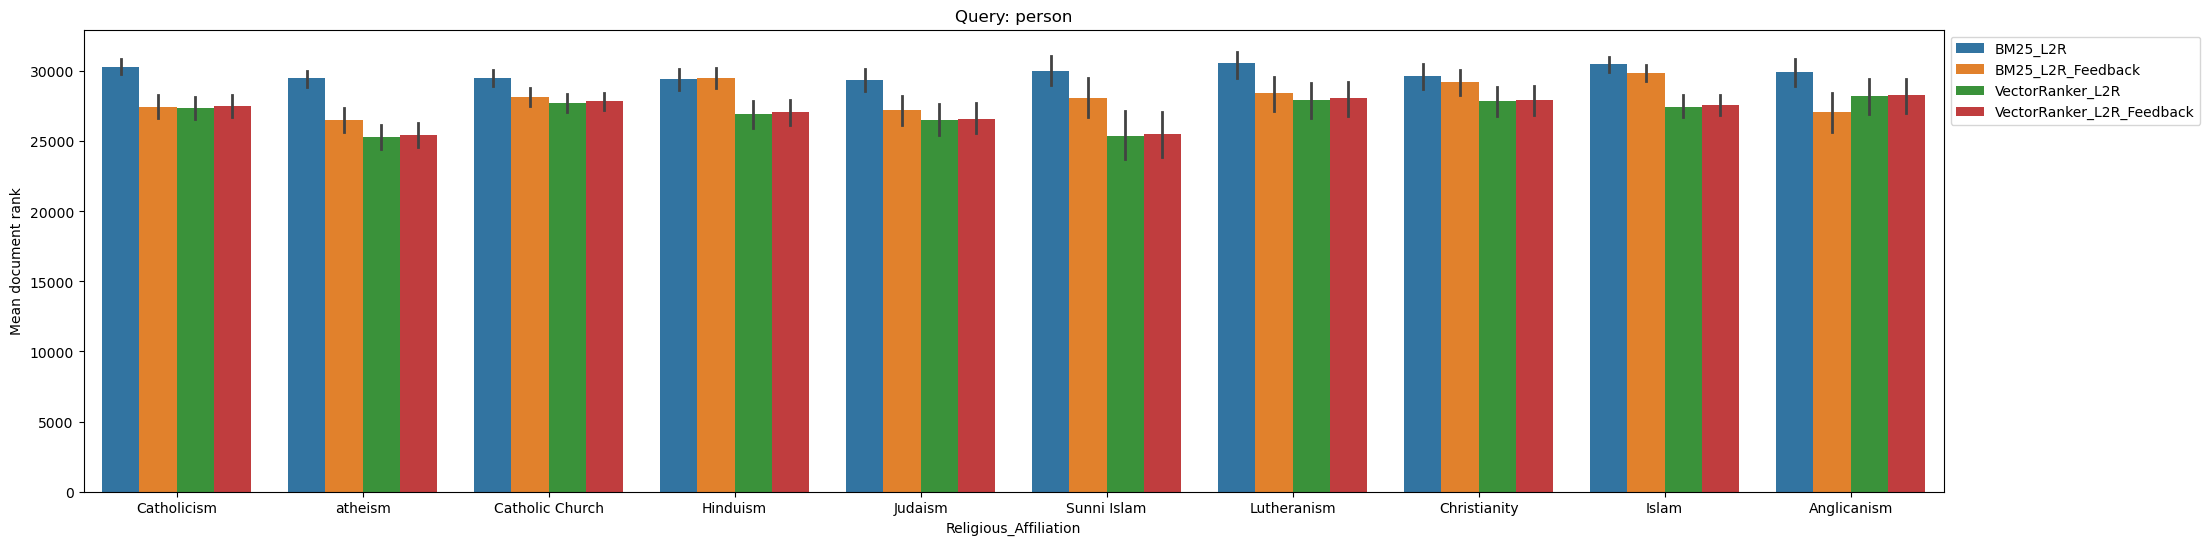

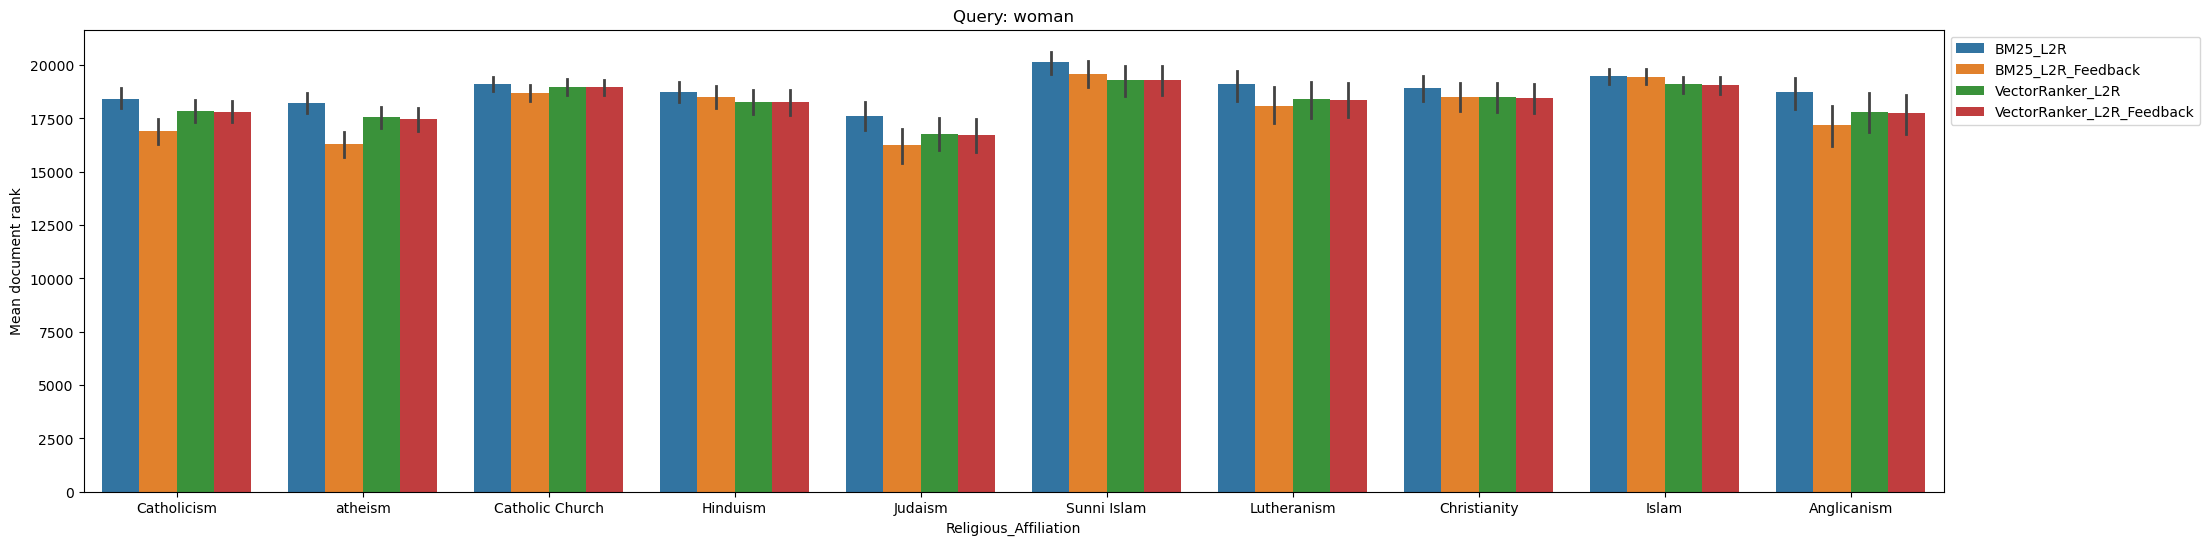

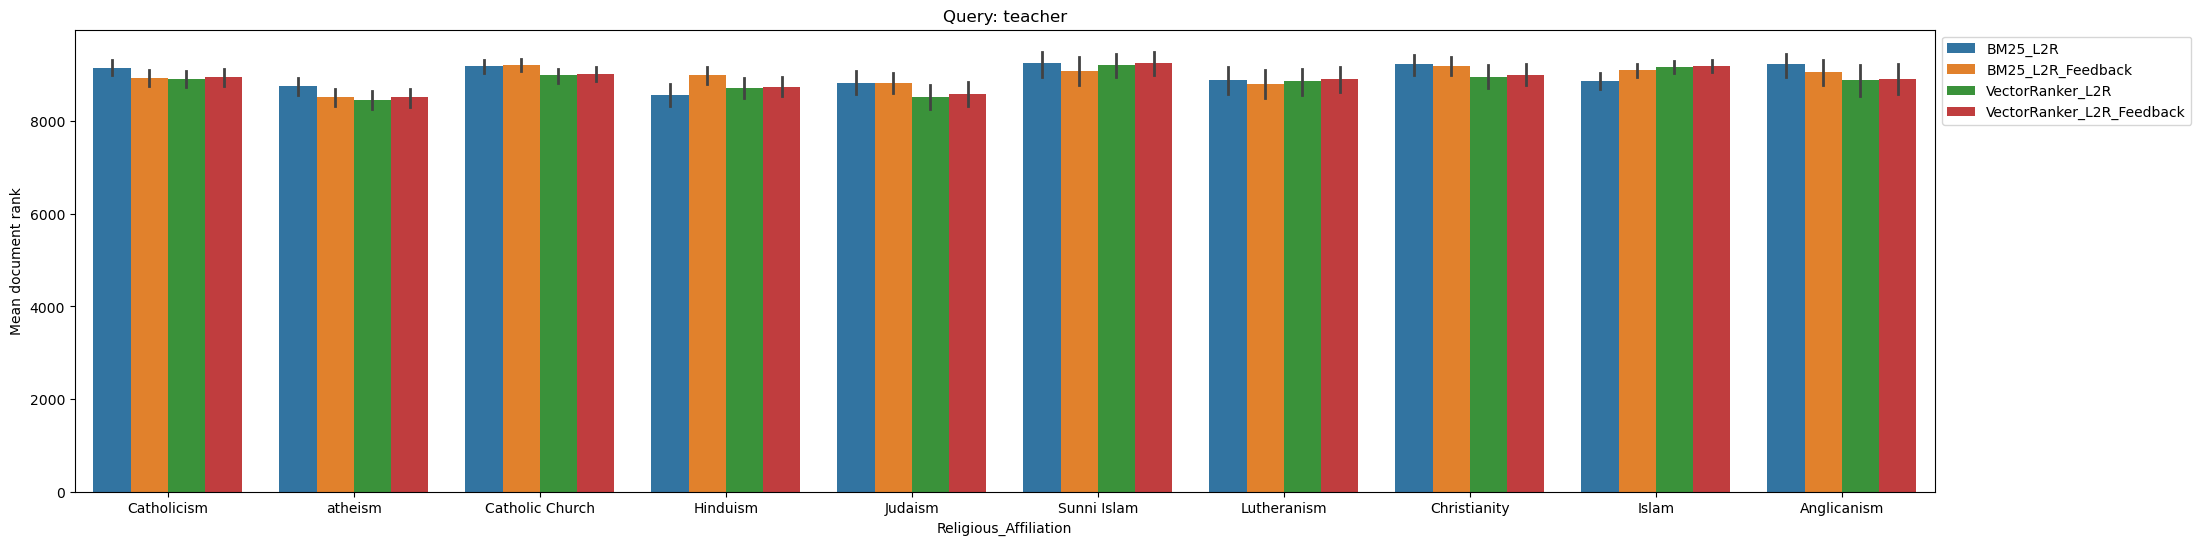

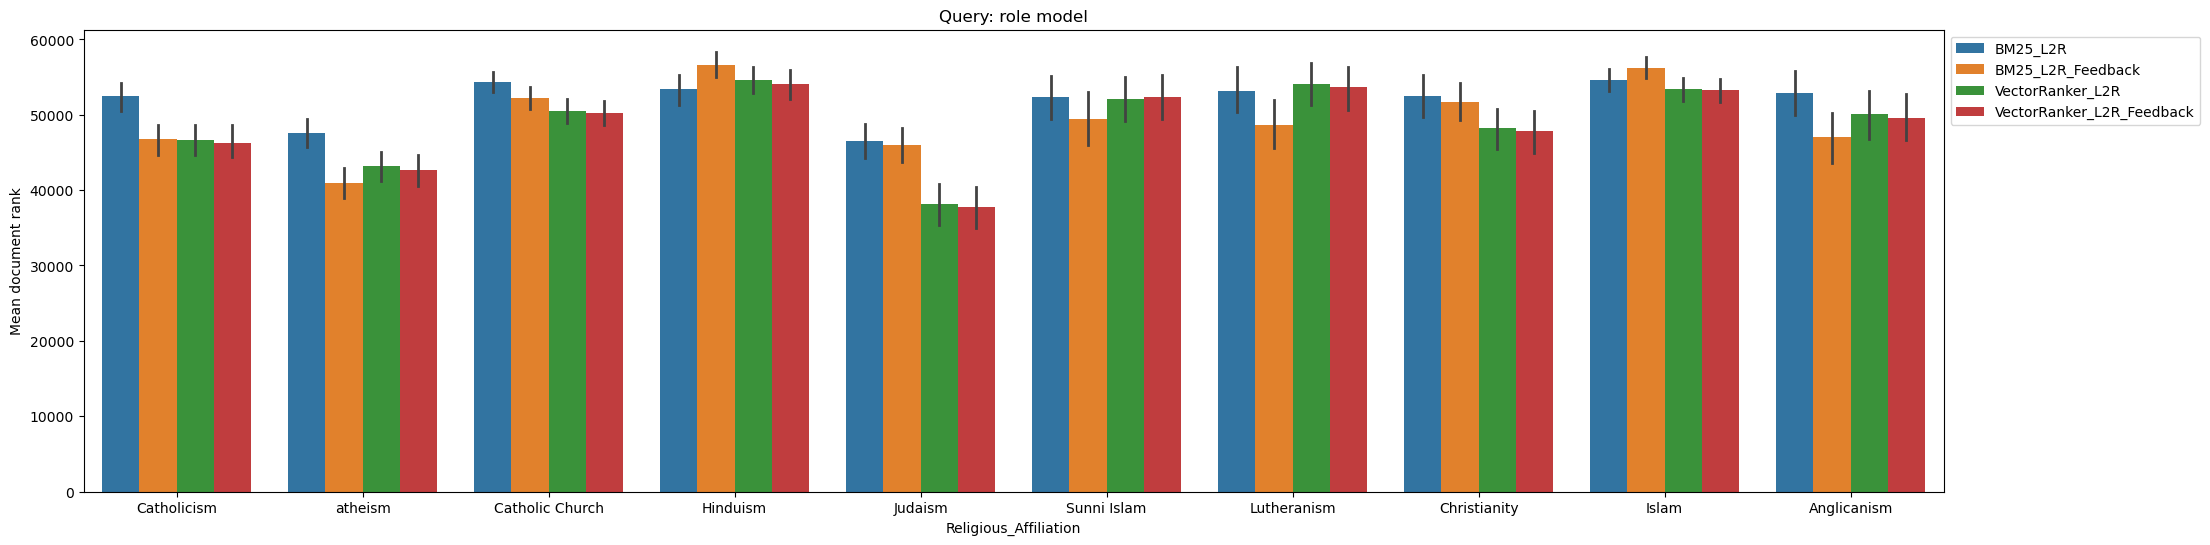

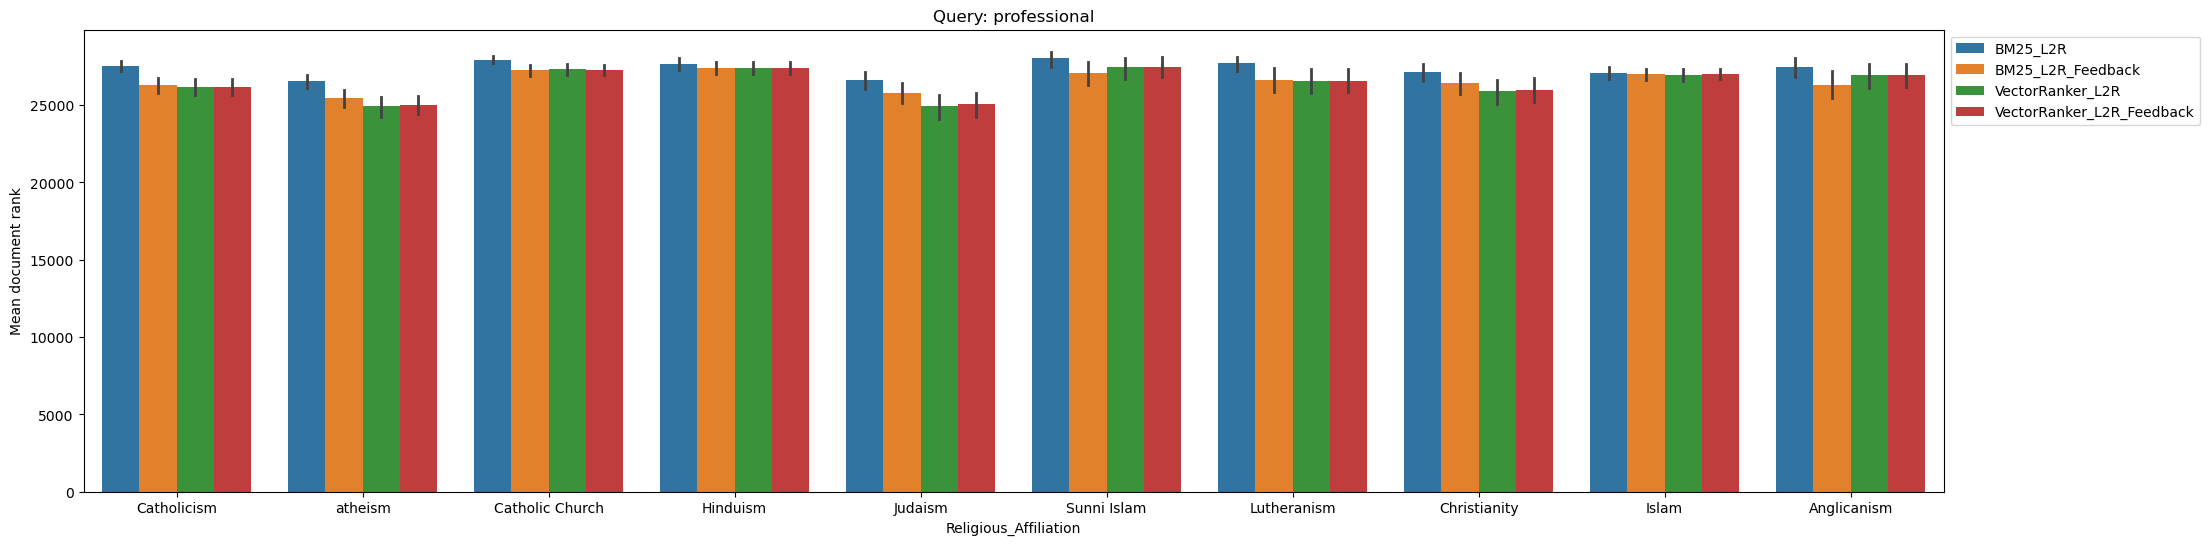

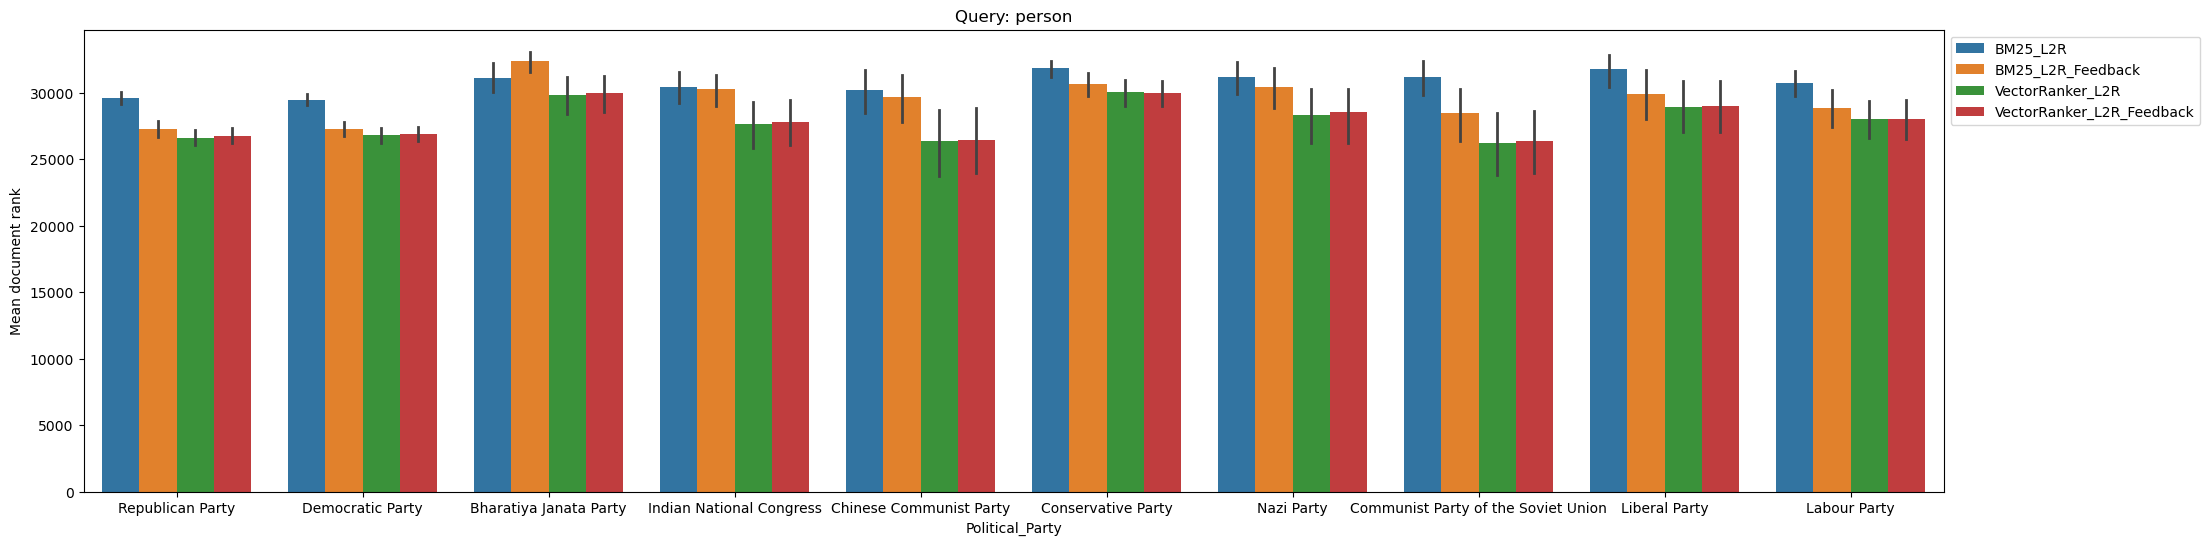

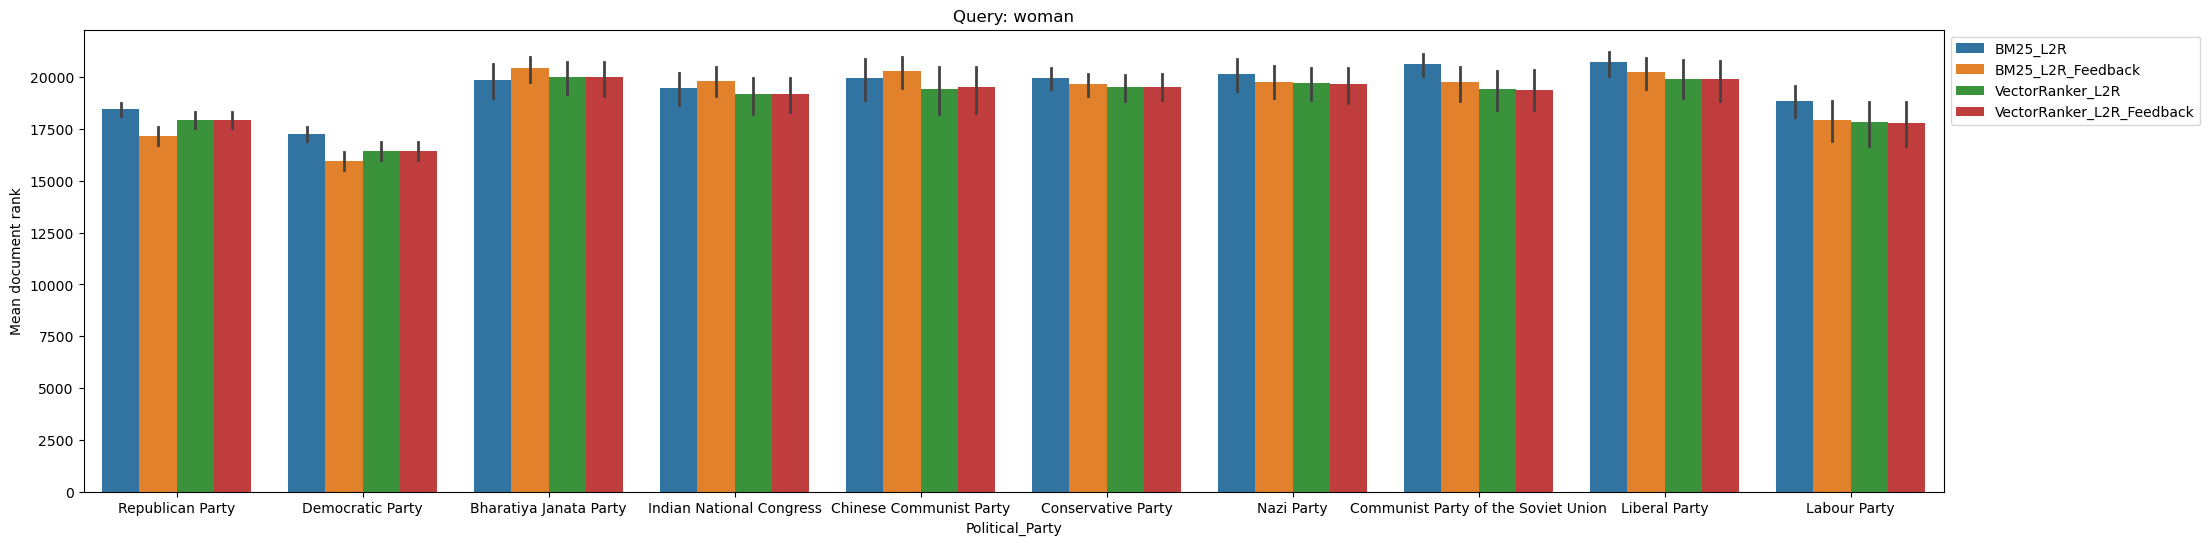

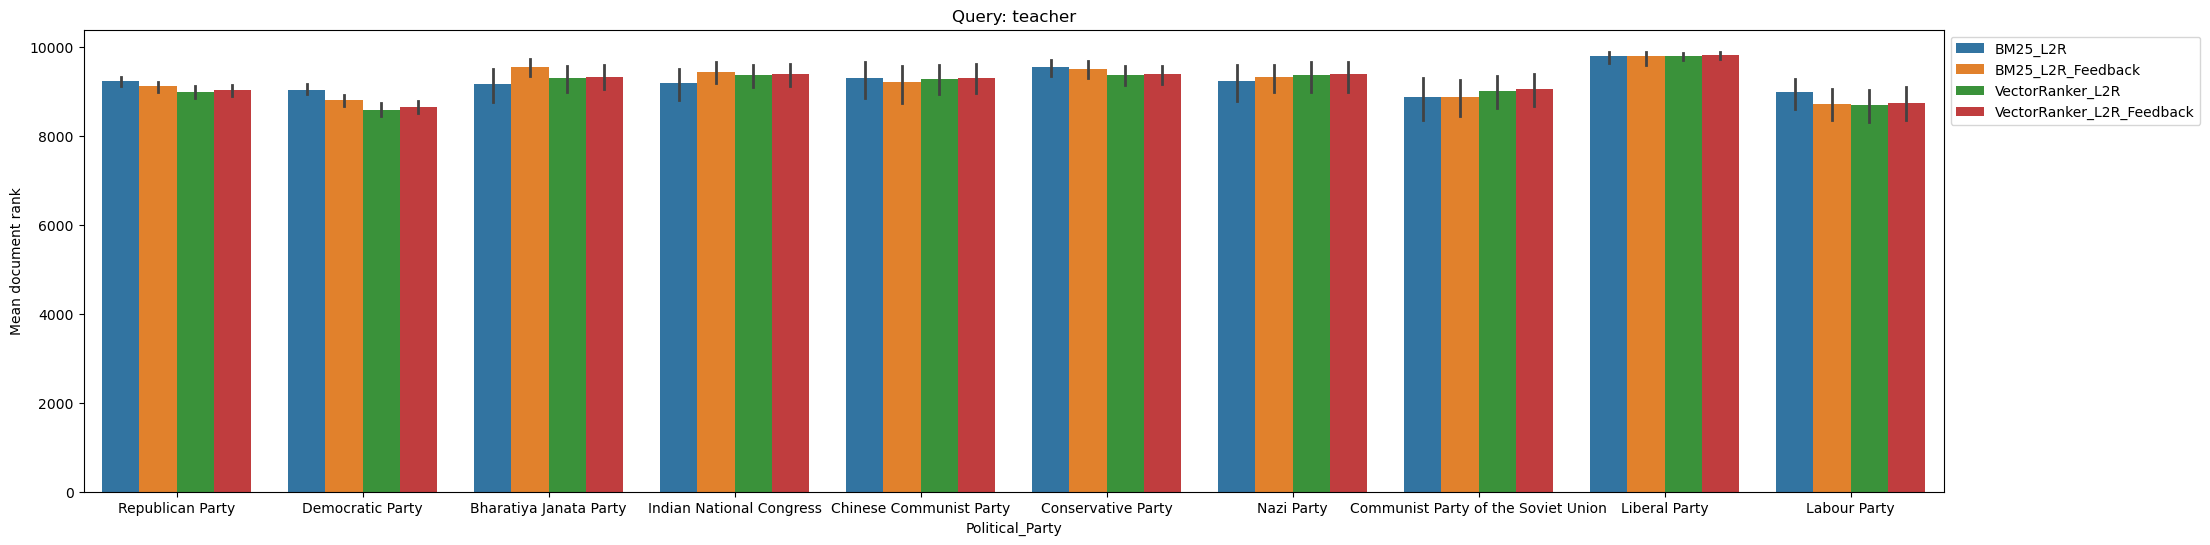

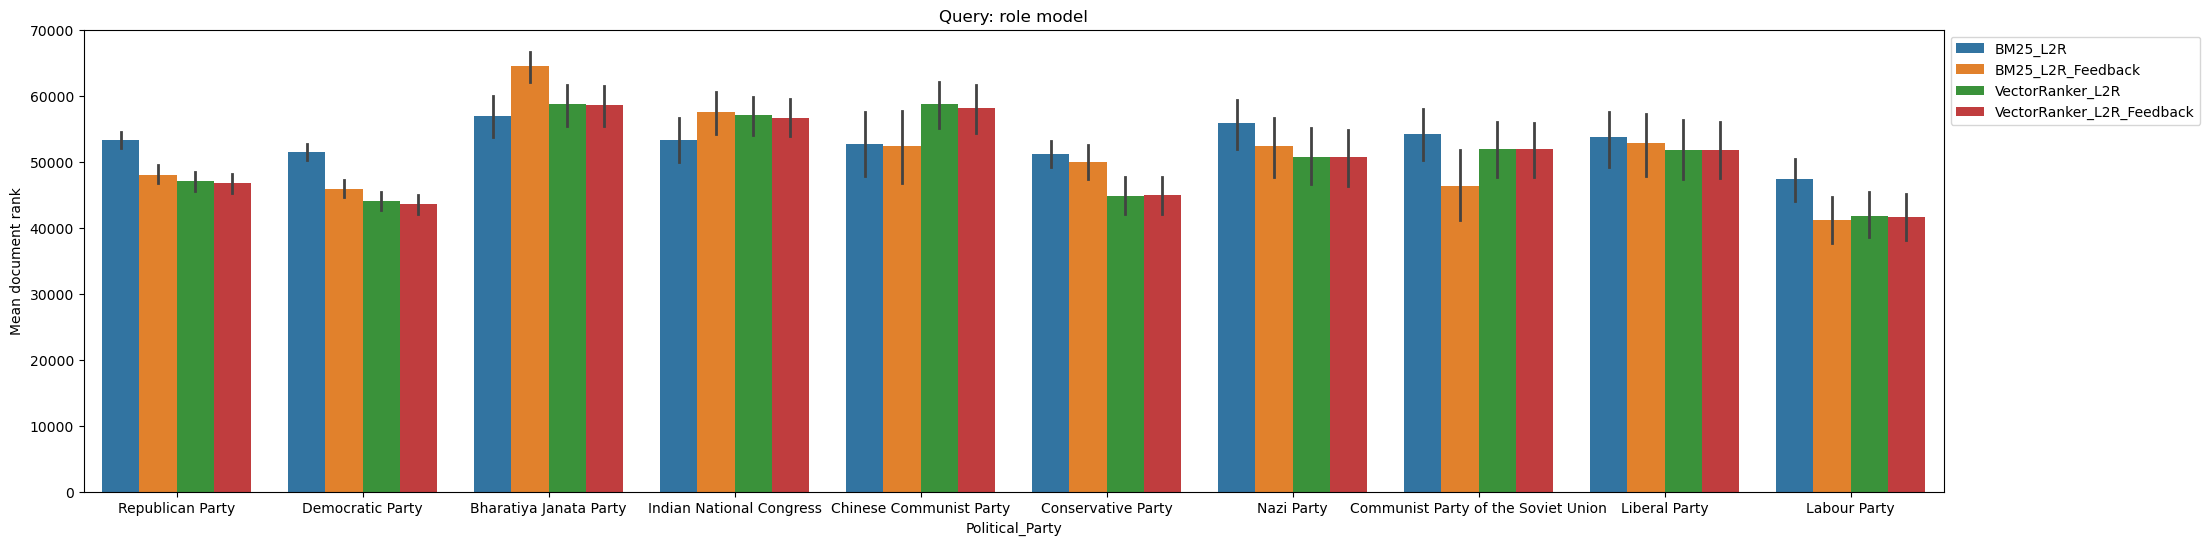

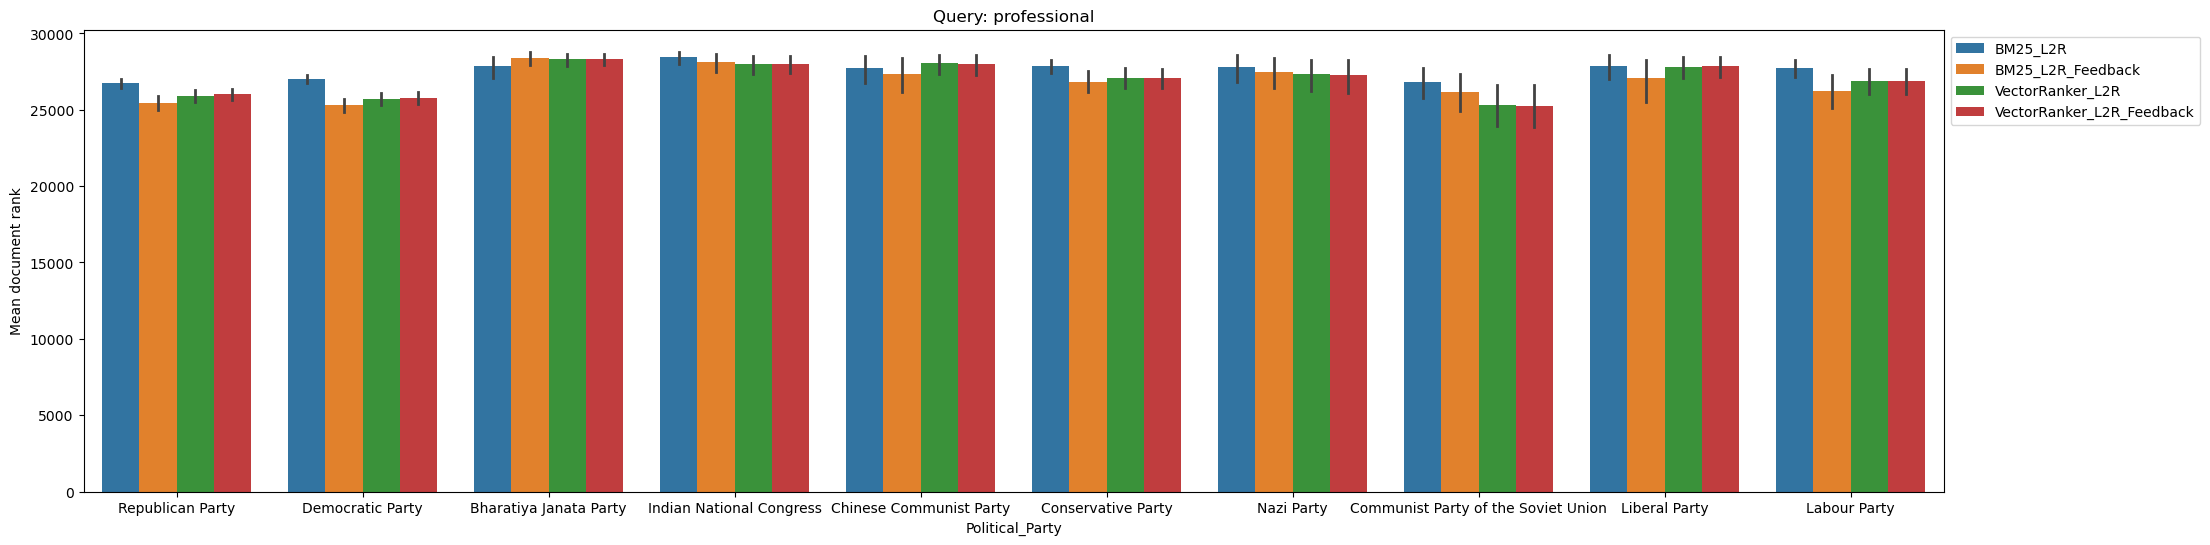

In [16]:
attr_names = ["Ethnicity", "Gender", "Religious_Affiliation", "Political_Party"]
for attr_name in attr_names:
    top_10_categories = top_10_attributes[attr_name]
    filtered_df = person_attr_df_rank[person_attr_df_rank[attr_name].isin(top_10_categories.keys())]
    for query in queries:
        new_df = []
        for model in pipe_name:
            model_df = filtered_df[["docid", model + "_" + query]].copy()
            model_df.columns = ["docid", "rank"]
            model_df["model"] = model
            model_df[attr_name] = filtered_df[attr_name]
            new_df.append(model_df)
        new_df = pd.concat(new_df)
        plt.figure(figsize=(24, 6))
        ax = sns.barplot(x=attr_name, y="rank", hue="model", data=new_df, errwidth=2)
        # ax.bar_label(ax.containers[0], fontsize=8, color='darkblue')
        # ax.bar_label(ax.containers[1], fontsize=8, color='darkorange')
        # ax.bar_label(ax.containers[2], fontsize=8, color='darkgreen')
        # ax.bar_label(ax.containers[3], fontsize=8, color='darkred')
        ax.set_title("Query: " + query)
        ax.set_ylabel("Mean document rank")
        ax.set_xlabel(attr_name)
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.savefig("rpt/figures/plots/" + attr_name + "_" + query + ".png", bbox_inches='tight')

In [18]:
person_attr_df_rank.columns

Index(['title', 'Ethnicity', 'Gender', 'Religious_Affiliation',
       'Political_Party', 'docid', 'BM25_L2R_person',
       'BM25_L2R_Feedback_person', 'VectorRanker_L2R_person',
       'VectorRanker_L2R_Feedback_person', 'BM25_L2R_woman',
       'BM25_L2R_Feedback_woman', 'VectorRanker_L2R_woman',
       'VectorRanker_L2R_Feedback_woman', 'BM25_L2R_teacher',
       'BM25_L2R_Feedback_teacher', 'VectorRanker_L2R_teacher',
       'VectorRanker_L2R_Feedback_teacher', 'BM25_L2R_role model',
       'BM25_L2R_Feedback_role model', 'VectorRanker_L2R_role model',
       'VectorRanker_L2R_Feedback_role model', 'BM25_L2R_professional',
       'BM25_L2R_Feedback_professional', 'VectorRanker_L2R_professional',
       'VectorRanker_L2R_Feedback_professional'],
      dtype='object')

In [40]:
import pandas as pd
from scipy.stats import f_oneway

person_attr_df_rank = pd.read_csv("person-attributes-ranked.csv")
attr_names = ["Ethnicity", "Gender", "Religious_Affiliation", "Political_Party"]

rank_columns = [
    'BM25_L2R_person',
    'BM25_L2R_Feedback_person', 'VectorRanker_L2R_person',
    'VectorRanker_L2R_Feedback_person', 'BM25_L2R_woman',
    'BM25_L2R_Feedback_woman', 'VectorRanker_L2R_woman',
    'VectorRanker_L2R_Feedback_woman', 'BM25_L2R_teacher',
    'BM25_L2R_Feedback_teacher', 'VectorRanker_L2R_teacher',
    'VectorRanker_L2R_Feedback_teacher', 'BM25_L2R_role model',
    'BM25_L2R_Feedback_role model', 'VectorRanker_L2R_role model',
    'VectorRanker_L2R_Feedback_role model', 'BM25_L2R_professional',
    'BM25_L2R_Feedback_professional', 'VectorRanker_L2R_professional',
    'VectorRanker_L2R_Feedback_professional'
]

q1_columns = [[name, name[:4] + "_fstat"] for name in attr_names]
q1_columns = [item for sublist in q1_columns for item in sublist]

q1_df = pd.DataFrame(columns=q1_columns, index=rank_columns)
for attr_name in attr_names:
    top_10_categories = top_10_attributes[attr_name]
    filtered_df = person_attr_df_rank[person_attr_df_rank[attr_name].isin(top_10_categories.keys())]
    lambda_df = lambda k: filtered_df[filtered_df[attr_name] == k].copy()
    groups_val = [lambda_df(k) for k in top_10_categories.keys()]
    for rank_col in rank_columns:
        values = [group[rank_col] for group in groups_val]
        f_stat, p_val = f_oneway(*values)
        q1_df.loc[rank_col, attr_name] = "T" if p_val < 0.05 else "F"
        q1_df.loc[rank_col, attr_name[:4] + "_fstat"] = round(f_stat, 3)
# q1_df.to_csv("q1_rank.csv")
q1_df

,Ethnicity,Ethn_fstat,Gender,Gend_fstat,Religious_Affiliation,Reli_fstat,Political_Party,Poli_fstat
BM25_L2R_person,F,1.818,T,9.58,F,1.837,T,4.637
BM25_L2R_Feedback_person,T,7.36,T,4.332,T,7.441,T,9.574
VectorRanker_L2R_person,T,4.461,T,2.4,T,3.861,T,4.734
VectorRanker_L2R_Feedback_person,T,4.841,T,2.32,T,3.885,T,4.663
BM25_L2R_woman,T,4.747,T,838.853,T,5.769,T,13.463
BM25_L2R_Feedback_woman,T,5.689,T,429.551,T,17.54,T,21.617
VectorRanker_L2R_woman,T,3.126,T,1162.057,T,7.291,T,13.52
VectorRanker_L2R_Feedback_woman,T,2.943,T,1152.982,T,7.439,T,13.684
BM25_L2R_teacher,F,1.113,F,1.842,T,5.156,T,3.223
BM25_L2R_Feedback_teacher,F,1.331,F,1.059,T,5.604,T,7.101


#### Problem 2

In [11]:
PERSONALIZATION = "personalization.jsonl"
personalitzation = []
with open(PERSONALIZATION, "r") as f:
    for line in f:
        personalitzation.append(json.loads(line))

In [12]:
personalized_weights = {}
for profile in personalitzation:
    user_id = profile["user_id"]
    preferred_docs = profile["seed_docs"]
    preferred_doc_ids = [doc["docid"] for doc in preferred_docs]
    personalized_weights[user_id] = {doc_id: 1 for doc_id in preferred_doc_ids}

In [13]:
doc_title_category = {}
for doc in tqdm(read_dataset(DATASET_PATH, 200_000, 1), total=200_000):
    doc_id = int(doc['docid'])
    doc_title_category[doc_id] = (doc['title'], doc['categories'])

100%|██████████| 200000/200000 [00:19<00:00, 10089.63it/s]


In [14]:
nf = NetworkFeatures()
g = nf.load_network('edgelist.csv.gz', 92650947)

100%|██████████| 92650947/92650947 [04:27<00:00, 346952.75it/s] 


In [16]:
results = {}
for user_id in personalized_weights:
    final_df = pd.DataFrame()
    node_to_index = {node: i for i, node in enumerate(g.names)}
    weights = {node_to_index[node]: weight for node, weight in personalized_weights[user_id].items()}
    final_df['pagerank'] = nf.calculate_page_rank(g, weights=weights)
    final_df['docid'] = g.names
    final_df['title'] = final_df['docid'].map(lambda x: doc_title_category[x][0] if x in doc_title_category else 'Not Found')
    final_df['categories'] = final_df['docid'].map(lambda x: doc_title_category[x][1] if x in doc_title_category else 'Not Found')
    results[user_id] = final_df
    final_df.to_csv(f'network_stats_{user_id}.csv', index=False)

In [17]:
df1 = pd.read_csv('network_stats_1.csv').sort_values(by='pagerank', ascending=False)[:20]['title'].values
df2 = pd.read_csv('network_stats_2.csv').sort_values(by='pagerank', ascending=False)[:20]['title'].values
df = pd.DataFrame()
df['user1'] = df1
df['user2'] = df2
df

,user1,user2
0,C (programming language),Sea otter
1,Object-oriented programming,Snow leopard
2,Data type,Giant otter
3,Class (computer programming),Veganism
4,Visual Studio Code,Yosemite National Park
5,Stack (abstract data type),American bison
6,Emacs,Deforestation and climate change
7,C standard library,Overpopulation
8,CUDA,Lemur
9,Open-source software development,Zookeeper


#### Problem 3

In [18]:
user_ids = list(results.keys())

In [19]:
q3_queries = ["python", "java", "debug"]
# different network stats
network_feats_1 = network_feats.copy()
for doc_id in network_feats_1:
    network_feats_1[doc_id]['pagerank'] = 0
for docid, pr_val in zip(results[user_ids[0]]['docid'], results[user_ids[0]]['pagerank']):
    network_feats_1[docid]['pagerank'] = pr_val

network_feats_2 = network_feats.copy()
for doc_id in network_feats_2:
    network_feats_2[doc_id]['pagerank'] = 0
for docid, pr_val in zip(results[user_ids[1]]['docid'], results[user_ids[1]]['pagerank']):
    network_feats_2[docid]['pagerank'] = pr_val

# CrossEncoderScorer
cescorer = CrossEncoderScorer(raw_text_dict)

# different feature extractors based on the network stats
q3_fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
            preprocessor, stopwords, recognized_categories,
            network_feats, cescorer)
q3_fe1 = L2RFeatureExtractor(main_index, title_index, doc_category_info,
            preprocessor, stopwords, recognized_categories,
            network_feats_1, cescorer)
q3_fe2 = L2RFeatureExtractor(main_index, title_index, doc_category_info,
            preprocessor, stopwords, recognized_categories,
            network_feats_2, cescorer)

q3_pipeline = L2RRanker(main_index, title_index, preprocessor, stopwords, vec_ranker, q3_fe)
q3_pipeline1 = L2RRanker(main_index, title_index, preprocessor, stopwords, vec_ranker, q3_fe1)
q3_pipeline2 = L2RRanker(main_index, title_index, preprocessor, stopwords, vec_ranker, q3_fe2)

q3_pipeline.model.load("p5_pipeline_l2r.txt")
# DO we need to train again?
q3_pipeline1.model.load("p5_pipeline_l2r.txt")
q3_pipeline2.model.load("p5_pipeline_l2r.txt")

Show the titles of 10 most relevant docs

In [20]:
q3_queries_df = []
for query in q3_queries:
    q3_results = q3_pipeline.query(query)[:10]
    q3_results1 = q3_pipeline1.query(query)[:10]
    q3_results2 = q3_pipeline2.query(query)[:10]
    query_df = pd.DataFrame()
    query_df['normal'] = [doc_title_category[doc_id][0] for doc_id, _ in q3_results]
    query_df['normal_score'] = [score for _, score in q3_results]
    query_df['user_1'] = [doc_title_category[doc_id][0] for doc_id, _ in q3_results1]
    query_df['user_1_score'] = [score for _, score in q3_results1]
    query_df['user_2'] = [doc_title_category[doc_id][0] for doc_id, _ in q3_results2]
    query_df['user_2_score'] = [score for _, score in q3_results2]
    query_df['query'] = query
    q3_queries_df.append(query_df)
q3_queries_df = pd.concat(q3_queries_df)
q3_queries_df.to_csv("q3_queries.csv", index=False)

In [21]:
q3_queries_df

,normal,normal_score,user_1,user_1_score,user_2,user_2_score,query
0,Monty Python,0.132928,Monty Python,0.132928,Monty Python,0.132928,python
1,Python (programming language),0.132928,Python (programming language),0.132928,Python (programming language),0.132928,python
2,Monty Python's Life of Brian,0.107113,Monty Python's Life of Brian,0.107113,Monty Python's Life of Brian,0.107113,python
3,Monty Python and the Holy Grail,0.107113,Monty Python and the Holy Grail,0.107113,Monty Python and the Holy Grail,0.107113,python
4,Burmese python,0.107113,Burmese python,0.107113,Burmese python,0.107113,python
5,Monty Python's Flying Circus,0.107113,Monty Python's Flying Circus,0.107113,Monty Python's Flying Circus,0.107113,python
6,Python Software Foundation License,0.097818,Python Software Foundation License,0.097818,Python Software Foundation License,0.097818,python
7,Python License,0.097818,Python License,0.097818,Python License,0.097818,python
8,Mod python,0.085573,Mod python,0.085573,Mod python,0.085573,python
9,CPython,0.078147,CPython,0.078147,CPython,0.078147,python


#### Problem 4

In [22]:
for profile in personalitzation:
    user_id = profile['user_id']
    seed_docs = profile['seed_docs']
    with open(f"personalization_{user_id}.jsonl", "w") as f:
        for doc in seed_docs:
            f.write(json.dumps(doc) + "\n")

In [23]:
# Create inverted index for both users
# user1_index = Indexer.create_index(
#     IndexType.InvertedIndex,
#     "personalization_1.jsonl",
#     preprocessor,
#     stopwords,
#     minimum_word_frequency=2,
#     doc_augment_dict=doc_augment_dict,
# )
# user1_index.save("user1_index")

# user2_index = Indexer.create_index(
#     IndexType.InvertedIndex,
#     "personalization_2.jsonl",
#     preprocessor,
#     stopwords,
#     minimum_word_frequency=2,
#     doc_augment_dict=doc_augment_dict,
# )
# user2_index.save("user2_index")

user1_index = Indexer.load_index("user1_index")
user2_index = Indexer.load_index("user2_index")

load index: 100%|██████████| 5048/5048 [00:00<00:00, 1027907.88it/s]


In [24]:
# BM25 ranker
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25, raw_text_dict=None)
personalized_bm25_1 = PersonalizedBM25(main_index, user1_index)
personalized_bm25_2 = PersonalizedBM25(main_index, user2_index)

# Create peronalized BM25 rankers
ranker1 = Ranker(main_index, preprocessor, stopwords, personalized_bm25_1, raw_text_dict=None)
ranker2 = Ranker(main_index, preprocessor, stopwords, personalized_bm25_2, raw_text_dict=None)

# Run the queries
q4_queries_df = []
for query in q3_queries:
    bm25_results = ranker.query(query)[:10]
    personalized_bm25_results1 = ranker1.query(query)[:10]
    personalized_bm25_results2 = ranker2.query(query)[:10]
    query_df = pd.DataFrame()
    query_df['normal'] = [doc_title_category[doc_id][0] for doc_id, _ in bm25_results]
    query_df['normal_score'] = [score for _, score in bm25_results]
    query_df['user_1'] = [doc_title_category[doc_id][0] for doc_id, _ in personalized_bm25_results1]
    query_df['user_1_score'] = [score for _, score in personalized_bm25_results1]
    query_df['user_2'] = [doc_title_category[doc_id][0] for doc_id, _ in personalized_bm25_results2]
    query_df['user_2_score'] = [score for _, score in personalized_bm25_results2]
    query_df['query'] = query
    q4_queries_df.append(query_df)
q4_queries_df = pd.concat(q4_queries_df)
q4_queries_df.to_csv("q4_queries.csv", index=False)

In [25]:
q4_queries_df

,normal,normal_score,user_1,user_1_score,user_2,user_2_score,query
0,Python (programming language),11.348012,Python (programming language),15.597758,Python (programming language),4.184372,python
1,CPython,11.248195,CPython,15.460559,CPython,4.147566,python
2,Python License,11.171931,Python License,15.355736,Python License,4.119445,python
3,Monty Python,11.147250,Monty Python,15.321811,Monty Python,4.110344,python
4,Pythonidae,11.127032,Pythonidae,15.294023,Pythonidae,4.102890,python
5,Jython,11.105209,Jython,15.264027,Jython,4.094843,python
6,Web Server Gateway Interface,11.069681,Web Server Gateway Interface,15.215193,Web Server Gateway Interface,4.081742,python
7,Python Software Foundation License,11.069052,Python Software Foundation License,15.214330,Python Software Foundation License,4.081511,python
8,PyPy,11.061188,PyPy,15.203521,PyPy,4.078611,python
9,Burmese python,11.034089,Burmese python,15.166273,Burmese python,4.068619,python


#### Problem 5

In [26]:
class TestVectorRanker:
    def __init__(self, ranker: VectorRanker, **kwargs):
        self.ranker = ranker
        self.kwargs = kwargs
    
    def query(self, query):
        return self.ranker.query(query, **self.kwargs)

In [28]:
cescorer = CrossEncoderScorer(raw_text_dict)
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
            preprocessor, stopwords, recognized_categories,
            network_feats, cescorer)

hyperparams_list = [
    (1, 0.9, 0.1),
    (1, 0.5, 0.5),
    (1, 0.1, 0.9),
    (5, 0.9, 0.1),
    (5, 0.5, 0.5),
    (5, 0.1, 0.9),
    (10, 0.9, 0.1),
    (10, 0.5, 0.5),
    (10, 0.1, 0.9),
]

results_info = {}
hyperparams_decorater = lambda x: {"pseudofeedback_num_docs": x[0], "pseduofeedback_alpha": x[1], "pseduofeedback_beta": x[2]}
hyperparams_list = [hyperparams_decorater(x) for x in hyperparams_list]
name_hyperparams = lambda hyperparams: str("model_" + "_".join([str(x) for x in hyperparams.values()]))

vec_ranker = VectorRanker(bi_encoder_name, encoded_docs, document_ids)

for hyperparams in hyperparams_list:
    print(hyperparams)
    test_ranker = TestVectorRanker(vec_ranker, **hyperparams)
    pipeline = L2RRanker(main_index, title_index, preprocessor, stopwords, test_ranker, fe)
    pipeline.model.load("p5_pipeline_l2r.txt")
    result_info = run_relevance_tests(RELEVANCE_TEST_DATA, pipeline)
    results_info[name_hyperparams(hyperparams)] = result_info

{'pseudofeedback_num_docs': 1, 'pseduofeedback_alpha': 0.9, 'pseduofeedback_beta': 0.1}


100%|██████████| 37/37 [03:39<00:00,  5.92s/it]


{'pseudofeedback_num_docs': 1, 'pseduofeedback_alpha': 0.5, 'pseduofeedback_beta': 0.5}


100%|██████████| 37/37 [04:08<00:00,  6.72s/it]


{'pseudofeedback_num_docs': 1, 'pseduofeedback_alpha': 0.1, 'pseduofeedback_beta': 0.9}


100%|██████████| 37/37 [04:07<00:00,  6.68s/it]


{'pseudofeedback_num_docs': 5, 'pseduofeedback_alpha': 0.9, 'pseduofeedback_beta': 0.1}


100%|██████████| 37/37 [04:30<00:00,  7.31s/it]


{'pseudofeedback_num_docs': 5, 'pseduofeedback_alpha': 0.5, 'pseduofeedback_beta': 0.5}


100%|██████████| 37/37 [04:32<00:00,  7.38s/it]


{'pseudofeedback_num_docs': 5, 'pseduofeedback_alpha': 0.1, 'pseduofeedback_beta': 0.9}


100%|██████████| 37/37 [04:43<00:00,  7.67s/it]


{'pseudofeedback_num_docs': 10, 'pseduofeedback_alpha': 0.9, 'pseduofeedback_beta': 0.1}


100%|██████████| 37/37 [05:12<00:00,  8.45s/it]


{'pseudofeedback_num_docs': 10, 'pseduofeedback_alpha': 0.5, 'pseduofeedback_beta': 0.5}


100%|██████████| 37/37 [05:09<00:00,  8.37s/it]


{'pseudofeedback_num_docs': 10, 'pseduofeedback_alpha': 0.1, 'pseduofeedback_beta': 0.9}


100%|██████████| 37/37 [05:06<00:00,  8.29s/it]


In [31]:
prev_infos = {}
with open("pipeline_info.json", "r") as f:
    prev_infos = json.load(f)

results_info['bm25_base'] = prev_infos['base']
results_info['hw2_l2r'] = prev_infos['l2r']
results_info['hw3_l2r'] = prev_infos['p5_pipeline']

In [32]:
with open("q5_results_info.json", "w") as f:
    json.dump(results_info, f)

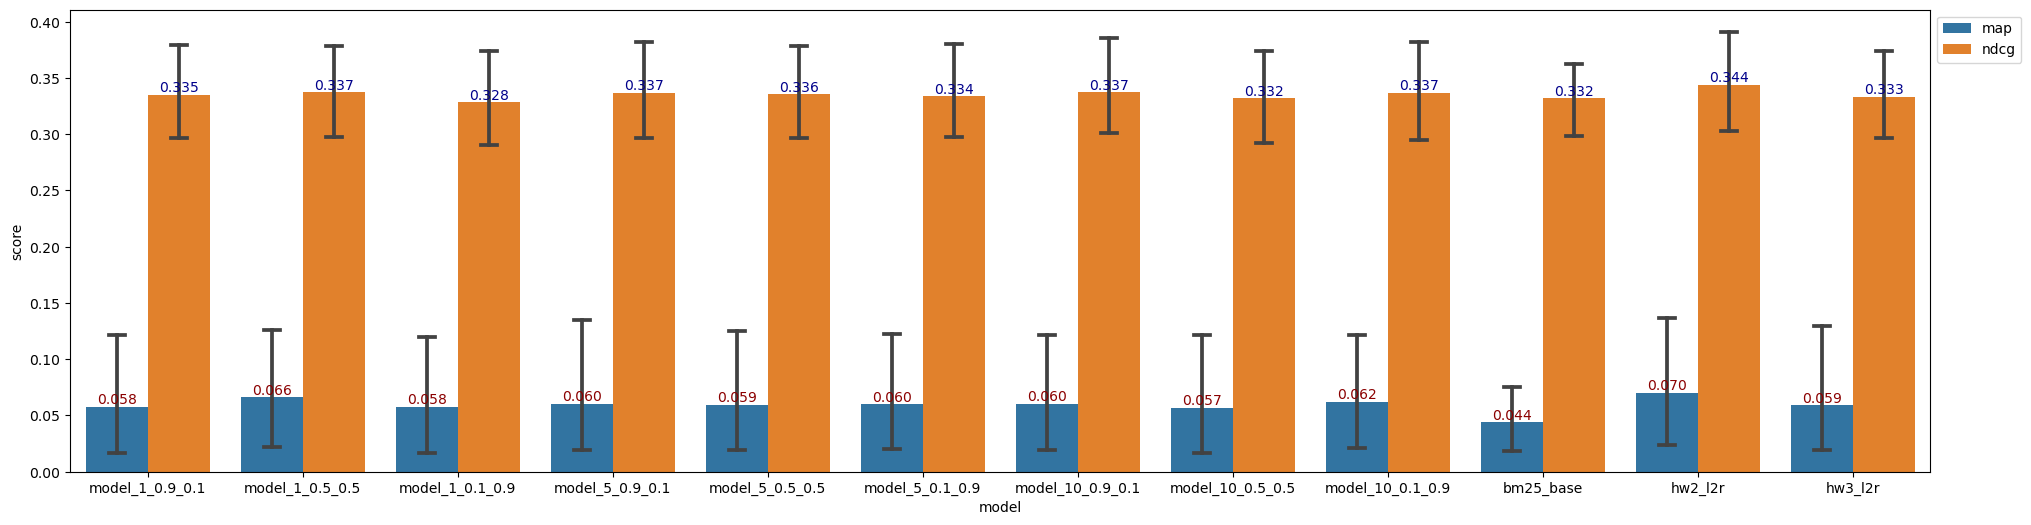

In [35]:
metric_add_func = lambda x, name: [(name, v) for v in x]
pipeline_df = pd.DataFrame(results_info).transpose().reset_index().rename(columns={'index': 'model'})
pipeline_df['score'] = pipeline_df[['map_scores', 'ndcg_scores']].apply(lambda x: metric_add_func(x[0], 'map') + metric_add_func(x[1], 'ndcg'), axis=1)
pipeline_df = pipeline_df.explode('score')
pipeline_df.drop(columns=['map', 'ndcg', 'map_scores', 'ndcg_scores'], inplace=True)
pipeline_df['metric'] = pipeline_df['score'].apply(lambda x: x[0])
pipeline_df['score'] = pipeline_df['score'].apply(lambda x: x[1])
pipeline_df['model'] = pipeline_df['model'].apply(lambda x: "pipeline_2" if x == "p5_pipeline" else x)
plt.figure(figsize=(24, 6))
ax = sns.barplot(data=pipeline_df, x='model', y='score', hue='metric', capsize=.1, errorbar='ci')
ax.bar_label(ax.containers[0], fontsize=10, color='darkred', fmt='%.3f')
ax.bar_label(ax.containers[1], fontsize=10, color='darkblue', fmt='%.3f')
plt.savefig('pipeline_metrics_extra.png', dpi=300, bbox_inches='tight')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))